# Food Detection Project

This notebook implements a food detection system using CNN models. The steps include:
1. Importing the data
2. Mapping images to classes
3. Creating annotations for training and testing
4. Displaying images with bounding boxes
5. Building and training CNN models for classification


In [14]:
# Import necessary libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Step 1: Import the Data

First, we'll import the data and create two dataframes:
1. A dataframe mapping imageID to image data & food type
2. A dataframe mapping imageID to bounding box data from annotations


In [15]:
# Define paths
data_dir = 'data/Food_101'
annotations_dir = 'data/annotations'

# Get all food categories
food_categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(f"Found {len(food_categories)} food categories: {food_categories}")


Found 17 food categories: ['ice_cream', 'samosa', 'donuts', 'waffles', 'falafel', 'ravioli', 'strawberry_shortcake', 'spring_rolls', 'hot_dog', 'apple_pie', 'chocolate_cake', 'tacos', 'pancakes', 'pizza', 'nachos', 'french_fries', 'onion_rings']


In [16]:
# Create a dataframe mapping imageID to image data & food type
image_data = []

for category in tqdm(food_categories, desc="Processing food categories"):
    category_dir = os.path.join(data_dir, category)
    image_files = glob.glob(os.path.join(category_dir, "*.jpg"))

    for img_path in image_files:
        img_filename = os.path.basename(img_path)
        img_id = os.path.splitext(img_filename)[0]  # Remove extension to get ID

        image_data.append({
            'image_id': img_id,
            'image_path': img_path,
            'food_type': category
        })

# Create the dataframe
image_df = pd.DataFrame(image_data)
print(f"Created image dataframe with {len(image_df)} entries")
image_df.head()


Processing food categories: 100%|██████████| 17/17 [00:00<00:00, 383.15it/s]

Created image dataframe with 16256 entries


image_id                           image_path  food_type
0  1795168  data/Food_101/ice_cream/1795168.jpg  ice_cream
1  3730391  data/Food_101/ice_cream/3730391.jpg  ice_cream
2  1052863  data/Food_101/ice_cream/1052863.jpg  ice_cream
3  2557070  data/Food_101/ice_cream/2557070.jpg  ice_cream
4  2217633  data/Food_101/ice_cream/2217633.jpg  ice_cream

In [17]:
# Function to parse XML annotation file
def parse_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Get image ID from filename
    filename = root.find('filename').text
    image_id = os.path.splitext(filename)[0]

    # Get image dimensions
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    # Get all objects (bounding boxes)
    boxes = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        boxes.append({
            'image_id': image_id,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax,
            'width': width,
            'height': height
        })

    return boxes


In [18]:
# Create a dataframe mapping imageID to bounding box data from annotations
annotation_data = []

# Get all annotation files
annotation_files = glob.glob(os.path.join(annotations_dir, "*.xml"))
print(f"Found {len(annotation_files)} annotation files")

# Parse each annotation file
for xml_path in tqdm(annotation_files, desc="Parsing annotation files"):
    boxes = parse_annotation(xml_path)
    annotation_data.extend(boxes)

# Create the dataframe
annotation_df = pd.DataFrame(annotation_data)
print(f"Created annotation dataframe with {len(annotation_df)} entries")
annotation_df.head()


Found 500 annotation files


Parsing annotation files: 100%|██████████| 500/500 [00:00<00:00, 7203.39it/s]

Created annotation dataframe with 553 entries


image_id         class  xmin  ymin  xmax  ymax  width  height
0   209662        nachos    65    80   430   289    512     382
1   172042  french_fries   102   164   512   389    512     512
2   248212        nachos    13    36   382   468    382     512
3   524839   onion_rings    71    11   427   463    512     512
4    74527   onion_rings   210    10   455   272    512     383

## Step 2: Map Training and Testing Images to Classes

Now we'll split the data into training and testing sets with a 70:30 ratio, ensuring that the same IDs are in corresponding train/test sets for both dataframes.


In [19]:
# Get unique image IDs that have annotations
annotated_image_ids = annotation_df['image_id'].unique()
print(f"Found {len(annotated_image_ids)} unique images with annotations")

# Get all unique image IDs
all_image_ids = image_df['image_id'].unique()
print(f"Found {len(all_image_ids)} total unique images")

# Create a mapping of image_id to food_type for stratified splitting
image_id_to_food_type = dict(zip(image_df['image_id'], image_df['food_type']))

# Create a DataFrame for annotated images with their food types for stratified splitting
annotated_df = pd.DataFrame({
    'image_id': annotated_image_ids,
    'food_type': [image_id_to_food_type[img_id] for img_id in annotated_image_ids]
})

# Split the annotated images into training and testing sets (70:30 ratio) with stratification by food type
train_annotated_df, test_annotated_df = train_test_split(
    annotated_df,
    test_size=0.3,
    random_state=42,
    stratify=annotated_df['food_type']  # Stratify by food type
)

# Extract the image IDs
train_annotated_ids = train_annotated_df['image_id'].values
test_annotated_ids = test_annotated_df['image_id'].values

print(f"Training set (annotated): {len(train_annotated_ids)} images")
print(f"Testing set (annotated): {len(test_annotated_ids)} images")

# Get non-annotated image IDs
non_annotated_ids = np.setdiff1d(all_image_ids, annotated_image_ids)
print(f"Non-annotated images: {len(non_annotated_ids)} images")

# Create a DataFrame for non-annotated images with their food types for stratified splitting
non_annotated_df = pd.DataFrame({
    'image_id': non_annotated_ids,
    'food_type': [image_id_to_food_type[img_id] for img_id in non_annotated_ids]
})

# Split non-annotated images into train and test with the same ratio, stratified by food type
train_non_annotated_df, test_non_annotated_df = train_test_split(
    non_annotated_df,
    test_size=0.3,
    random_state=42,
    stratify=non_annotated_df['food_type']  # Stratify by food type
)

# Extract the image IDs
train_non_annotated_ids = train_non_annotated_df['image_id'].values
test_non_annotated_ids = test_non_annotated_df['image_id'].values

# Combine annotated and non-annotated IDs for final train/test sets
train_ids = np.concatenate([train_annotated_ids, train_non_annotated_ids])
test_ids = np.concatenate([test_annotated_ids, test_non_annotated_ids])

print(f"Final training set: {len(train_ids)} images")
print(f"Final testing set: {len(test_ids)} images")


Found 500 unique images with annotations
Found 16256 total unique images
Training set (annotated): 350 images
Testing set (annotated): 150 images
Non-annotated images: 15756 images
Final training set: 11379 images
Final testing set: 4877 images


In [20]:
# Create training and testing dataframes for images (using all images)
train_image_df = image_df[image_df['image_id'].isin(train_ids)]
test_image_df = image_df[image_df['image_id'].isin(test_ids)]

# Create training and testing dataframes for annotations (only for annotated images)
train_annotation_df = annotation_df[annotation_df['image_id'].isin(train_annotated_ids)]
test_annotation_df = annotation_df[annotation_df['image_id'].isin(test_annotated_ids)]

print(f"Training image dataframe: {len(train_image_df)} entries")
print(f"Testing image dataframe: {len(test_image_df)} entries")
print(f"Training annotation dataframe: {len(train_annotation_df)} entries")
print(f"Testing annotation dataframe: {len(test_annotation_df)} entries")

# Verify that the stratification is working correctly
print("\nVerifying stratification by food category:")
train_food_counts = train_image_df['food_type'].value_counts(normalize=True)
test_food_counts = test_image_df['food_type'].value_counts(normalize=True)

# Display the distribution of food types in training and testing sets
print("\nTraining set food type distribution (%):")
print(train_food_counts * 100)
print("\nTesting set food type distribution (%):")
print(test_food_counts * 100)

# Calculate the difference in distribution
print("\nDifference in distribution (percentage points):")
food_types = set(train_food_counts.index) | set(test_food_counts.index)
for food_type in food_types:
    train_pct = train_food_counts.get(food_type, 0) * 100
    test_pct = test_food_counts.get(food_type, 0) * 100
    diff = abs(train_pct - test_pct)
    print(f"{food_type}: {diff:.2f}pp")


Training image dataframe: 11379 entries
Testing image dataframe: 4877 entries
Training annotation dataframe: 389 entries
Testing annotation dataframe: 164 entries

Verifying stratification by food category:

Training set food type distribution (%):
food_type
ice_cream               6.151683
samosa                  6.151683
french_fries            6.151683
nachos                  6.151683
pizza                   6.151683
pancakes                6.151683
tacos                   6.151683
chocolate_cake          6.151683
hot_dog                 6.151683
spring_rolls            6.151683
strawberry_shortcake    6.151683
ravioli                 6.151683
falafel                 6.151683
waffles                 6.151683
donuts                  6.151683
onion_rings             6.151683
apple_pie               1.573073
Name: proportion, dtype: float64

Testing set food type distribution (%):
food_type
ice_cream               6.151323
samosa                  6.151323
french_fries            6.1513

## Step 3: Create Annotations for Training and Testing Images

The annotations have already been created and loaded into our dataframes. Let's examine the distribution of classes in our annotations.


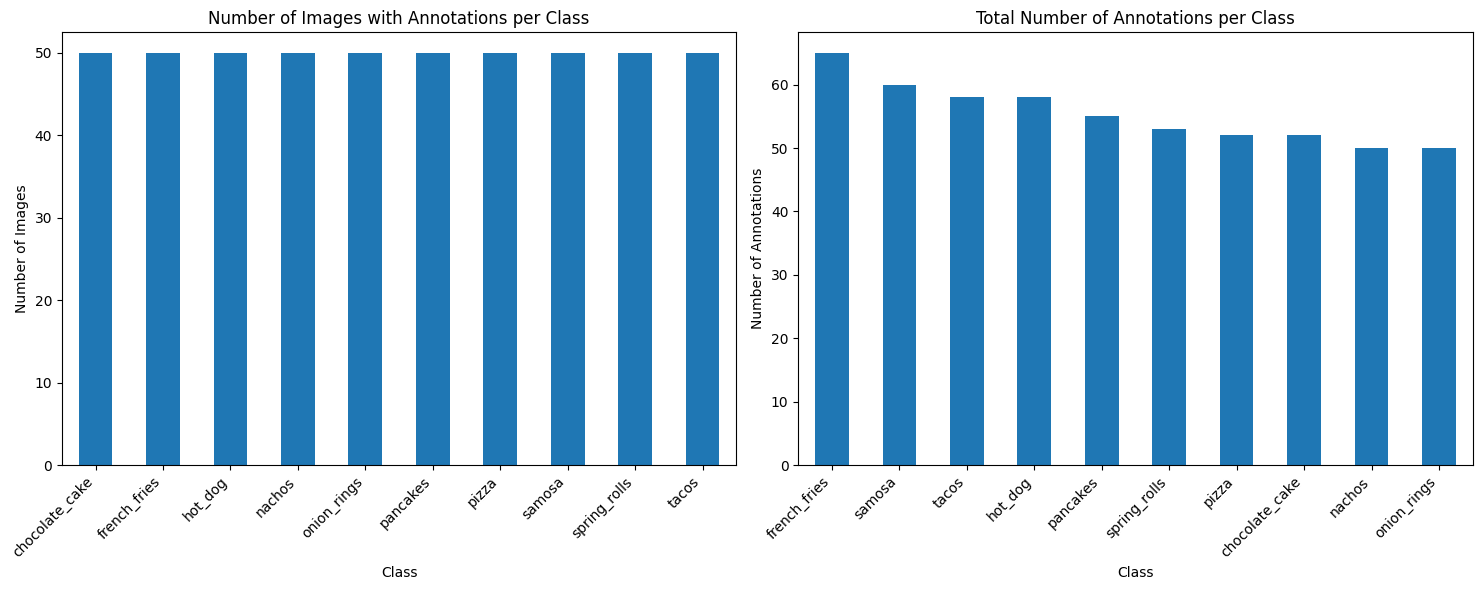

In [22]:
# Count the number of images with annotations per class
images_with_annotations = annotation_df.groupby('class')['image_id'].nunique()

# Count total number of annotations per class
annotations_per_class = annotation_df['class'].value_counts()

# Create subplots
plt.figure(figsize=(15, 6))

# Plot 1: Images with annotations per class
plt.subplot(1, 2, 1)
images_with_annotations.plot(kind='bar')
plt.title('Number of Images with Annotations per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')

# Plot 2: Total annotations per class  
plt.subplot(1, 2, 2)
annotations_per_class.plot(kind='bar')
plt.title('Total Number of Annotations per Class')
plt.xlabel('Class')
plt.ylabel('Number of Annotations')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## Step 4: Display Images with Bounding Boxes

Now let's display some images with their bounding boxes to verify our data.


In [35]:
# Function to display an image with its bounding boxes
def display_image_with_boxes(image_id, image_df, annotation_df):
    # Get image path
    image_row = image_df[image_df['image_id'] == image_id].iloc[0]
    image_path = image_row['image_path']
    food_type = image_row['food_type']

    # Get annotations for this image
    boxes = annotation_df[annotation_df['image_id'] == image_id]

    # Load and display the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    plt.figure(figsize=(10, 8))
    plt.imshow(img)

    # Draw bounding boxes
    for _, box in boxes.iterrows():
        xmin, ymin, xmax, ymax = box['xmin'], box['ymin'], box['xmax'], box['ymax']
        class_name = box['class']

        # Create rectangle
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                            fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

        # Add label
        plt.text(xmin, ymin - 5, class_name, 
                 bbox=dict(facecolor='red', alpha=0.5), fontsize=12, color='white')

    plt.title(f"Image ID: {image_id}, Food Type: {food_type}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Images with annotations:


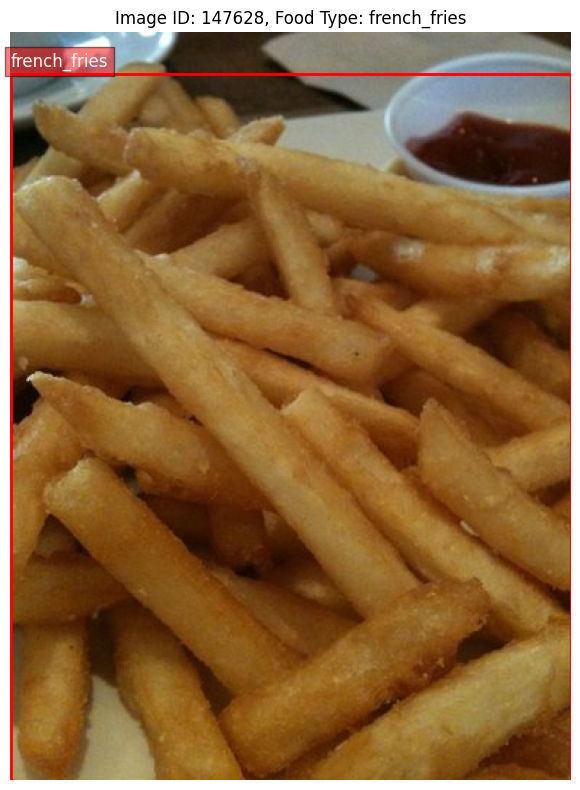

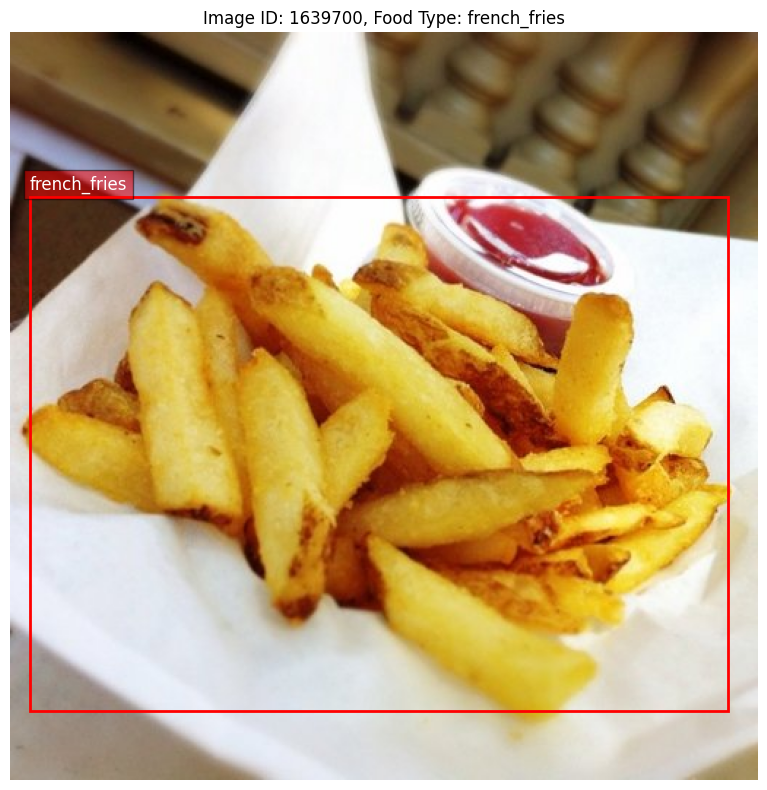


Images without annotations:


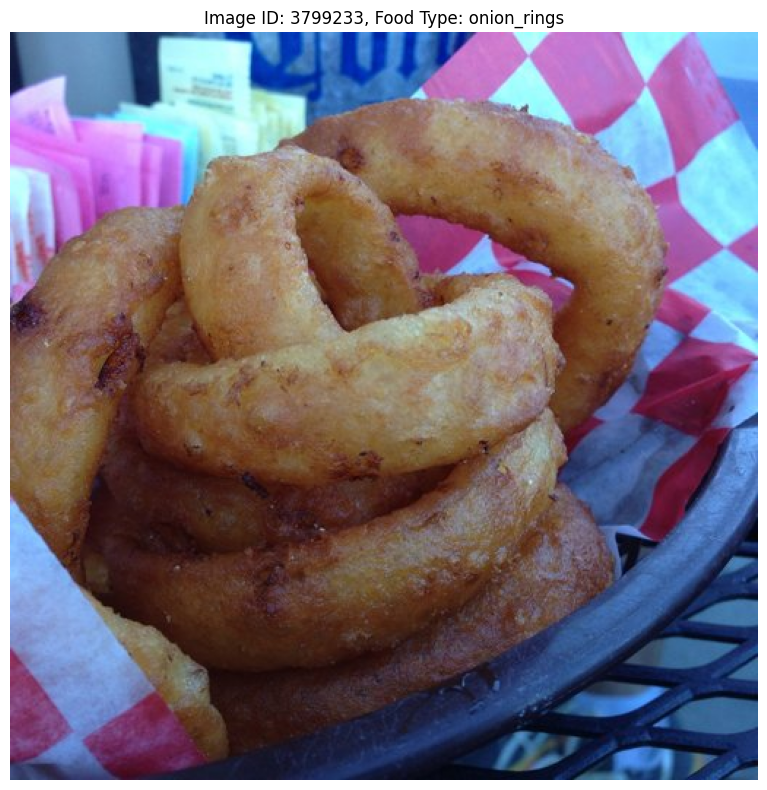

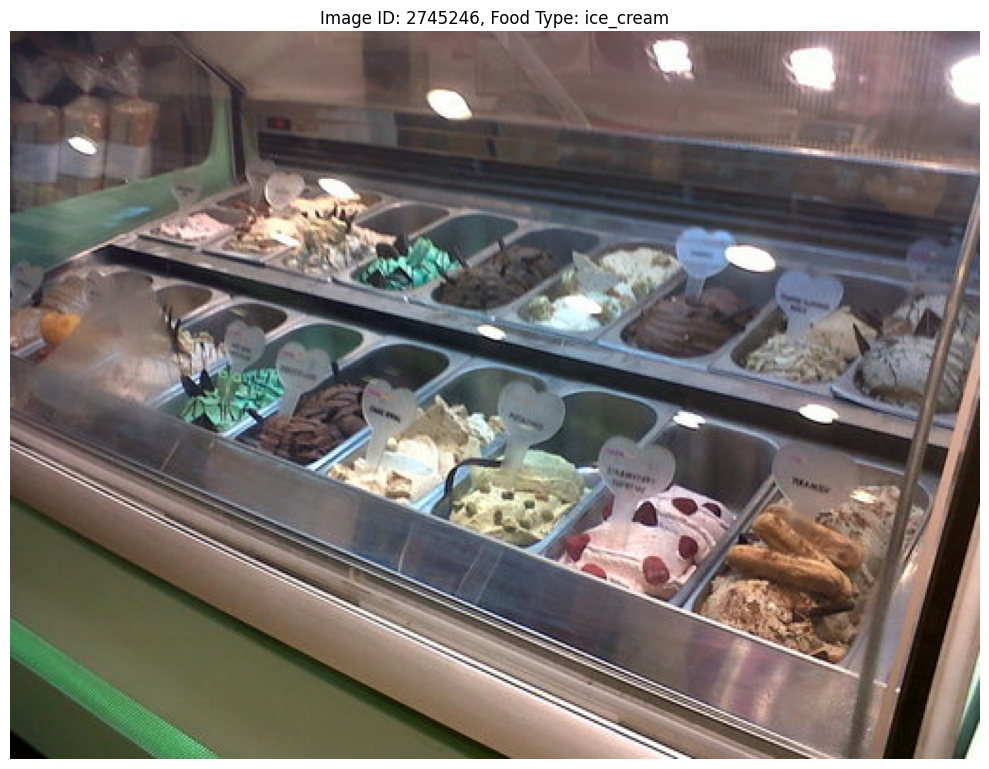

In [36]:
# Get a mix of annotated and non-annotated image IDs
annotated_sample = np.random.choice(annotated_image_ids, size=2, replace=False)
non_annotated_sample = np.random.choice(non_annotated_ids, size=2, replace=False)

# Display annotated images
print("Images with annotations:")
for img_id in annotated_sample:
    display_image_with_boxes(img_id, image_df, annotation_df)

# Display non-annotated images
print("\nImages without annotations:")
for img_id in non_annotated_sample:
    display_image_with_boxes(img_id, image_df, annotation_df)


## Step 5: Design, Train and Test Basic CNN Models

Now we'll build and train a CNN model for food classification. We'll use a pre-trained MobileNetV2 model as the base and add our own classification layers on top.


In [37]:
# Function to load and preprocess an image for the CNN model
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img


In [38]:
# Create a mapping from food type to numeric label
unique_food_types = image_df['food_type'].unique()
food_to_label = {food: i for i, food in enumerate(unique_food_types)}
label_to_food = {i: food for food, i in food_to_label.items()}

print(f"Number of unique food types: {len(unique_food_types)}")
print("Food type to label mapping:")
for food, label in food_to_label.items():
    print(f"{food}: {label}")


Number of unique food types: 17
Food type to label mapping:
ice_cream: 0
samosa: 1
donuts: 2
waffles: 3
falafel: 4
ravioli: 5
strawberry_shortcake: 6
spring_rolls: 7
hot_dog: 8
apple_pie: 9
chocolate_cake: 10
tacos: 11
pancakes: 12
pizza: 13
nachos: 14
french_fries: 15
onion_rings: 16


In [39]:
# Create data augmentation for training
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

# Prepare training and testing datasets
def prepare_dataset(image_df, batch_size=32, is_training=False):
    # Create lists of image paths and labels
    image_paths = image_df['image_path'].tolist()
    labels = [food_to_label[food_type] for food_type in image_df['food_type']]

    # Create a dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Map the function to preprocess images
    dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x), y), 
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Apply data augmentation only to the training set
    if is_training:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        # Shuffle the training dataset
        dataset = dataset.shuffle(buffer_size=1000)

    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

# Create training and testing datasets
train_dataset = prepare_dataset(train_image_df, is_training=True)
test_dataset = prepare_dataset(test_image_df, is_training=False)


In [40]:
# Build the CNN model using transfer learning with fine-tuning
def build_model(num_classes):
    # Load the pre-trained MobileNetV2 model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the bottom layers of the base model
    for layer in base_model.layers[:-30]:  # Freeze all except the last 30 layers
        layer.trainable = False

    # Check how many layers are trainable
    trainable_count = sum(1 for layer in base_model.layers if layer.trainable)
    print(f"Number of trainable layers in base model: {trainable_count} out of {len(base_model.layers)}")

    # Create the model with more complex top layers
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Use a lower learning rate for fine-tuning
    optimizer = optimizers.Adam(learning_rate=0.0001)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
model = build_model(len(unique_food_types))
model.summary()


Number of trainable layers in base model: 30 out of 154


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,626,129 (10.02 MB)

 Trainable params: 1,891,985 (7.22 MB)

 Non-trainable params: 734,144 (2.80 MB)

In [41]:
# Define callbacks for training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

# Train the model with more epochs and callbacks
history = model.fit(
    train_dataset,
    epochs=30,  # Increased from 10 to 30
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 77s 210ms/step - accuracy: 0.2662 - loss: 2.4742 - val_accuracy: 0.0744 - val_loss: 2.9299 - learning_rate: 1.0000e-04
Epoch 2/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 77s 216ms/step - accuracy: 0.2504 - loss: 2.4936 - val_accuracy: 0.0662 - val_loss: 3.0050 - learning_rate: 1.0000e-04
Epoch 3/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 83s 231ms/step - accuracy: 0.2402 - loss: 2.4711 - val_accuracy: 0.0757 - val_loss: 3.0465 - learning_rate: 1.0000e-04
Epoch 4/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.2275 - loss: 2.4485
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
356/356 ━━━━━━━━━━━━━━━━━━━━ 83s 231ms/step - accuracy: 0.2276 - loss: 2.4481 - val_accuracy: 0.0861 - val_loss: 3.0786 - learning_rate: 1.0000e-04
Epoch 5/30
341/356 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.1038 - loss: 2.8465

KeyboardInterrupt: 

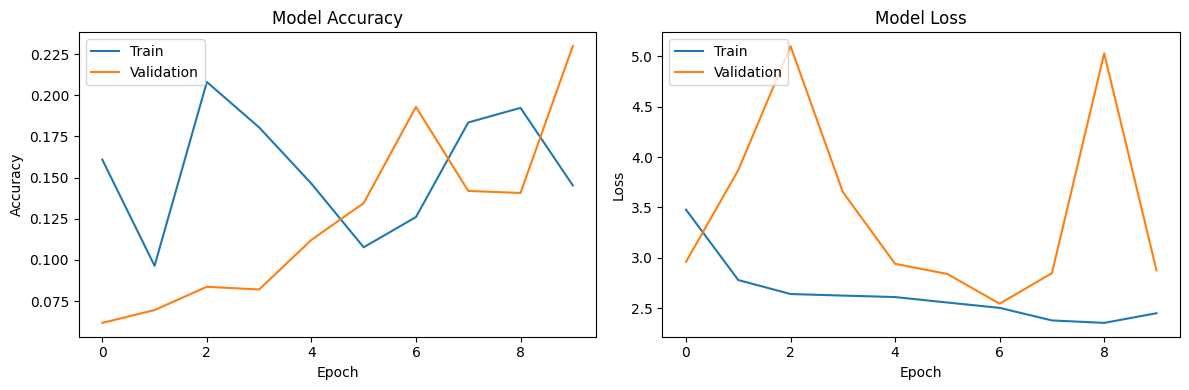

In [33]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

# Check if we've reached the target accuracy
if test_accuracy >= 0.8:
    print(f"✅ Target accuracy of 80% achieved! Current accuracy: {test_accuracy*100:.2f}%")
else:
    print(f"❌ Target accuracy of 80% not reached. Current accuracy: {test_accuracy*100:.2f}%")

# Get predictions for all test images
all_predictions = []
all_true_labels = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    all_predictions.extend(predicted_classes)
    all_true_labels.extend(labels.numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Calculate per-class accuracy
class_accuracies = {}
for food_type, label in food_to_label.items():
    mask = (all_true_labels == label)
    if np.sum(mask) > 0:  # Avoid division by zero
        class_acc = np.mean(all_predictions[mask] == all_true_labels[mask])
        class_accuracies[food_type] = class_acc

# Display per-class accuracies
print("\nPer-class accuracies:")
for food_type, acc in sorted(class_accuracies.items(), key=lambda x: x[1]):
    print(f"{food_type}: {acc*100:.2f}%")


In [ ]:
# Function to make predictions and display results
def predict_and_display(image_id, image_df, annotation_df, model):
    # Get image path
    image_row = image_df[image_df['image_id'] == image_id].iloc[0]
    image_path = image_row['image_path']
    true_food_type = image_row['food_type']

    # Load and preprocess the image
    img = load_and_preprocess_image(image_path)
    img_batch = tf.expand_dims(img, 0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_batch)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_food_type = label_to_food[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]

    # Get annotations for this image
    boxes = annotation_df[annotation_df['image_id'] == image_id]

    # Load and display the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    plt.figure(figsize=(10, 8))
    plt.imshow(img)

    # Draw bounding boxes
    for _, box in boxes.iterrows():
        xmin, ymin, xmax, ymax = box['xmin'], box['ymin'], box['xmax'], box['ymax']
        class_name = box['class']

        # Create rectangle
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                            fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

        # Add label
        plt.text(xmin, ymin - 5, class_name, 
                 bbox=dict(facecolor='red', alpha=0.5), fontsize=12, color='white')

    # Add prediction information
    title = f"Image ID: {image_id}\nTrue: {true_food_type}, Predicted: {predicted_food_type} ({confidence:.2f})"
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return predicted_food_type, confidence


In [ ]:
# Test the model on a few random images from the test set
random_test_ids = np.random.choice(test_ids, size=5, replace=False)
for img_id in random_test_ids:
    predict_and_display(img_id, image_df, annotation_df, model)


In [ ]:
# Save the model
model.save('models/food_classification_model.h5')
print("Model saved successfully!")


## Conclusion

In this notebook, we have:
1. Imported the food image data and annotations
2. Created dataframes mapping images to classes and bounding box annotations
3. Split the data into training and testing sets
4. Displayed images with their bounding boxes
5. Built, trained, and tested a CNN model for food classification

The model can be further improved by:
- Fine-tuning the pre-trained layers
- Using data augmentation to increase the training set size
- Trying different architectures or hyperparameters
- Implementing object detection to locate and classify food items simultaneously
